# Dados de reservas em excesso durante o tempo da pandemia

É prática usual em todo o mundo que os bancos do setor financeiro privado sejam obrigados a manter uma proporção fixa dos depósitos à vista de seus balanços em forma de reservas depositadas no Banco Central. Entretanto, os bancos costumam demandar mais reservas do que o imposto pela regulação. Uma interpretação possível é de que as reservas, por serem um tipo de ativo de alta liquidez, servem para os bancos como proteção contra incerteza sobre o futuro. Aparentemente, a demanda por reservas aumentou após a OMS declarar a pandemia como problema global, em Março de 2020. Os dados foram conseguidos no site do Banco Central Europeu. Esse projeto usa as abordagens de estudo de eventos, interrupted time series e teste de chow para avaliar se a pandemia teve impacto causal no acúmulo excessivo de reservas no setor financeiro privado. A intuição é de que a situação criada pela pandemia atuou no sentido de fazer com que os agentes do setor financeiro ficassem mais incertos quanto ao futuro da economia. Por isso, os agentes decidiram adotar uma postura mais defensiva ao compor mais de seus portfólios em ativos líquidos como forma de proteção. 

# Técnicas usadas

1. Testes de Chow

2. Interrupted Time Series

3. Estudo de Evento usando ARIMA

Tomando como base principal o capítulo 17 do livro [The Effect](https://theeffectbook.net/ch-EventStudies.html?panelset=python-code)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'
import statsmodels.api as sm 
from scipy.stats import f
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

C:\Users\joaop\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Reservas em excesso

In [2]:
# importando e ajeitando os dados 

df = pd.read_csv(r"C:\Users\joaop\Documents\credit rationing paper\ECB Data Excess Reserves.csv")

df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d')

df.set_index('DATE', inplace = True)

df = df.drop('TIME PERIOD', axis = 1)

lista = [df.columns[i].split()[12] for i in range(len(df.columns.to_list()))]

lista[-1] = 'Euro Area'

dic = dict(zip(df.columns,lista))

df = df.rename(columns = dic)

df

,Austria,Belgium,Cyprus,Germany,Estonia,Spain,Finland,France,Greece,Ireland,...,Lithuania,Luxembourg,Latvia,Malta,Netherlands,Portugal,Slovenia,Slovakia,Croatia,Euro Area
DATE,,,,,,,,,,,,,,,,,,,,,
1999-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1017.00
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1605.00
1999-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1106.00
1999-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1034.00
1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,941.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31,130.13,136.76,16.53,2298.53,41.99,440.16,239.64,1946.27,77.46,219.97,...,96.00,1496.37,5.15,23.28,132.21,304.20,5.19,3.23,45.42,8175.34
2024-03-31,99.27,97.37,7.11,2133.68,40.83,399.68,173.58,1442.02,38.00,204.87,...,131.02,1379.60,4.97,8.81,393.19,283.97,5.37,3.30,17.00,7238.34
2024-04-30,734.27,348.42,10.62,1793.25,40.08,640.24,253.47,1114.82,41.48,154.28,...,75.42,748.49,5.79,7.87,110.14,261.08,17.33,6.32,19.42,6798.51


Text(0.5, 0, 'Date')

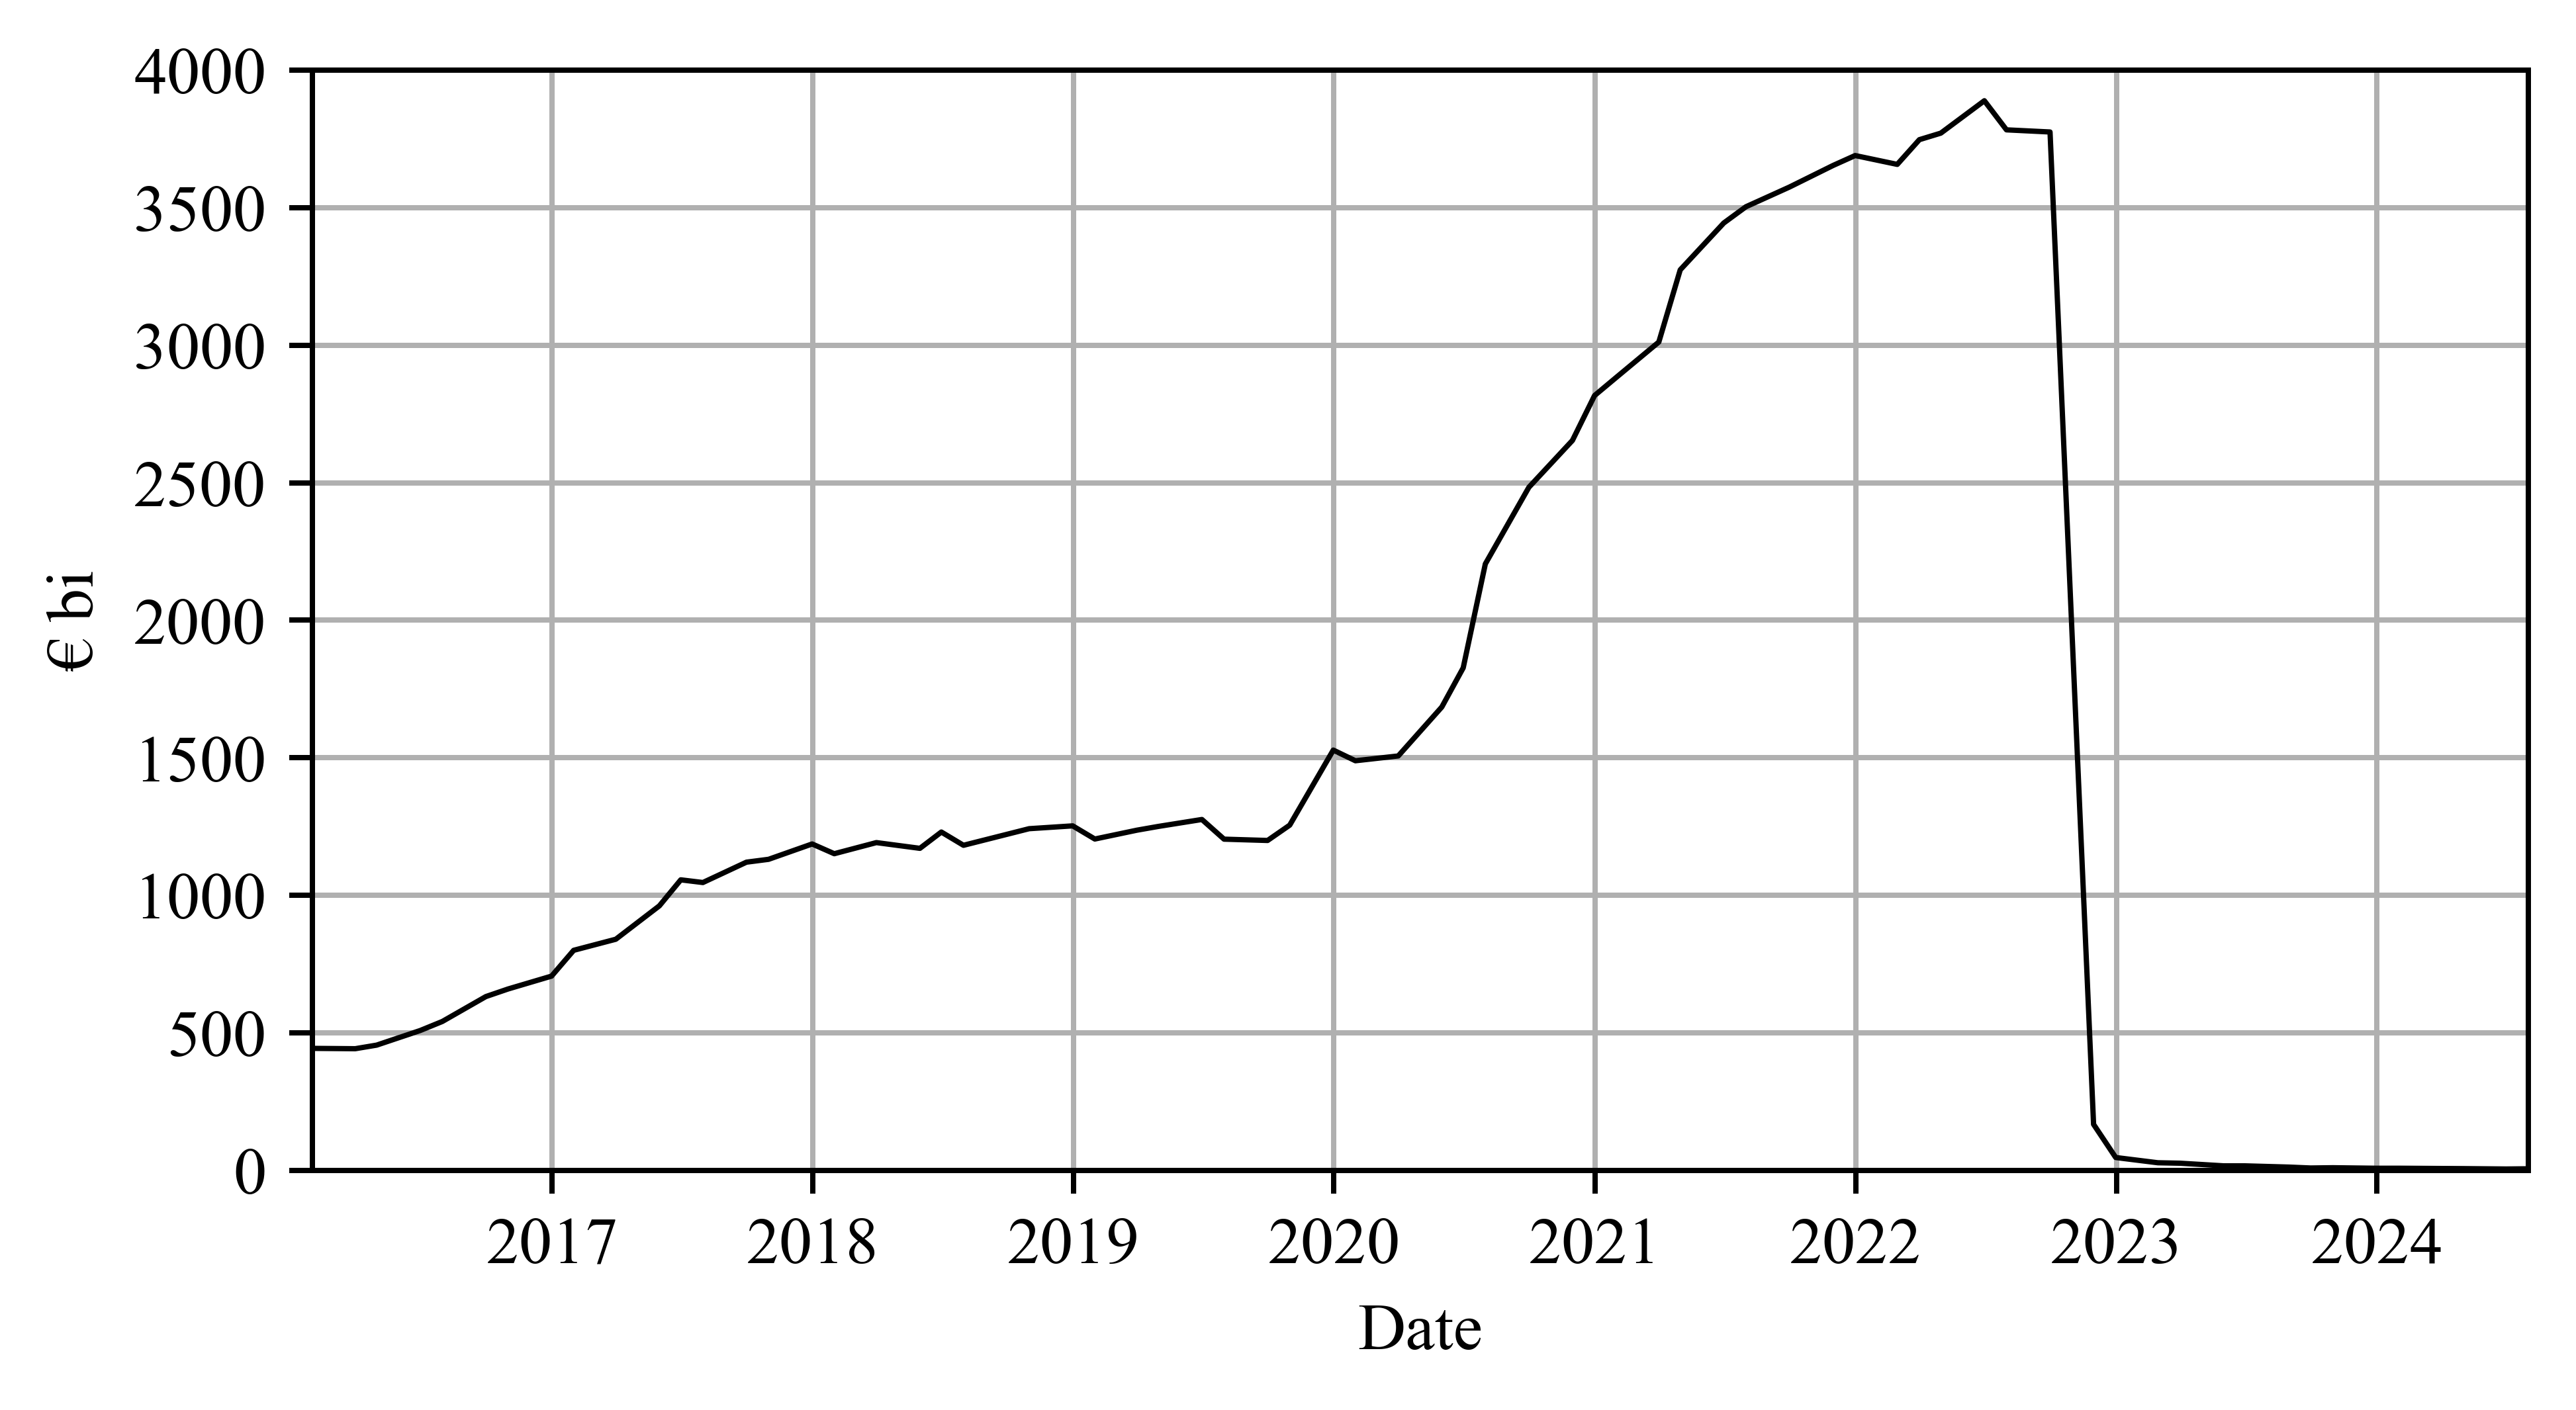

In [3]:
# Olhando a trajetória para a zona do Euro no agregado

fig, ax = plt.subplots(figsize = (6,3), dpi = 720)

ax.plot(df.loc['2016':].index, df.loc[df.index.year > 2015]['Euro Area']/1000, linewidth = 0.8, color = 'black')

ax.grid()

ax.set_xlim(df.loc['2016':].index[0],df.loc['2016':].index[-1])

ax.set_ylim(0,4000)

ax.set_ylabel('€ bi')
ax.set_xlabel('Date')

A partir do gráfico acima, fica aparente que, antes de 2020, a quantidade de reservas em excesso seguia uma trajetória aparentemente estável. Após 2020, a curva assume uma inclinação positiva acentuada. A queda vista observada no final de 2022 se deve à introdução de um novo ativo pela autoridade monetária europeia.

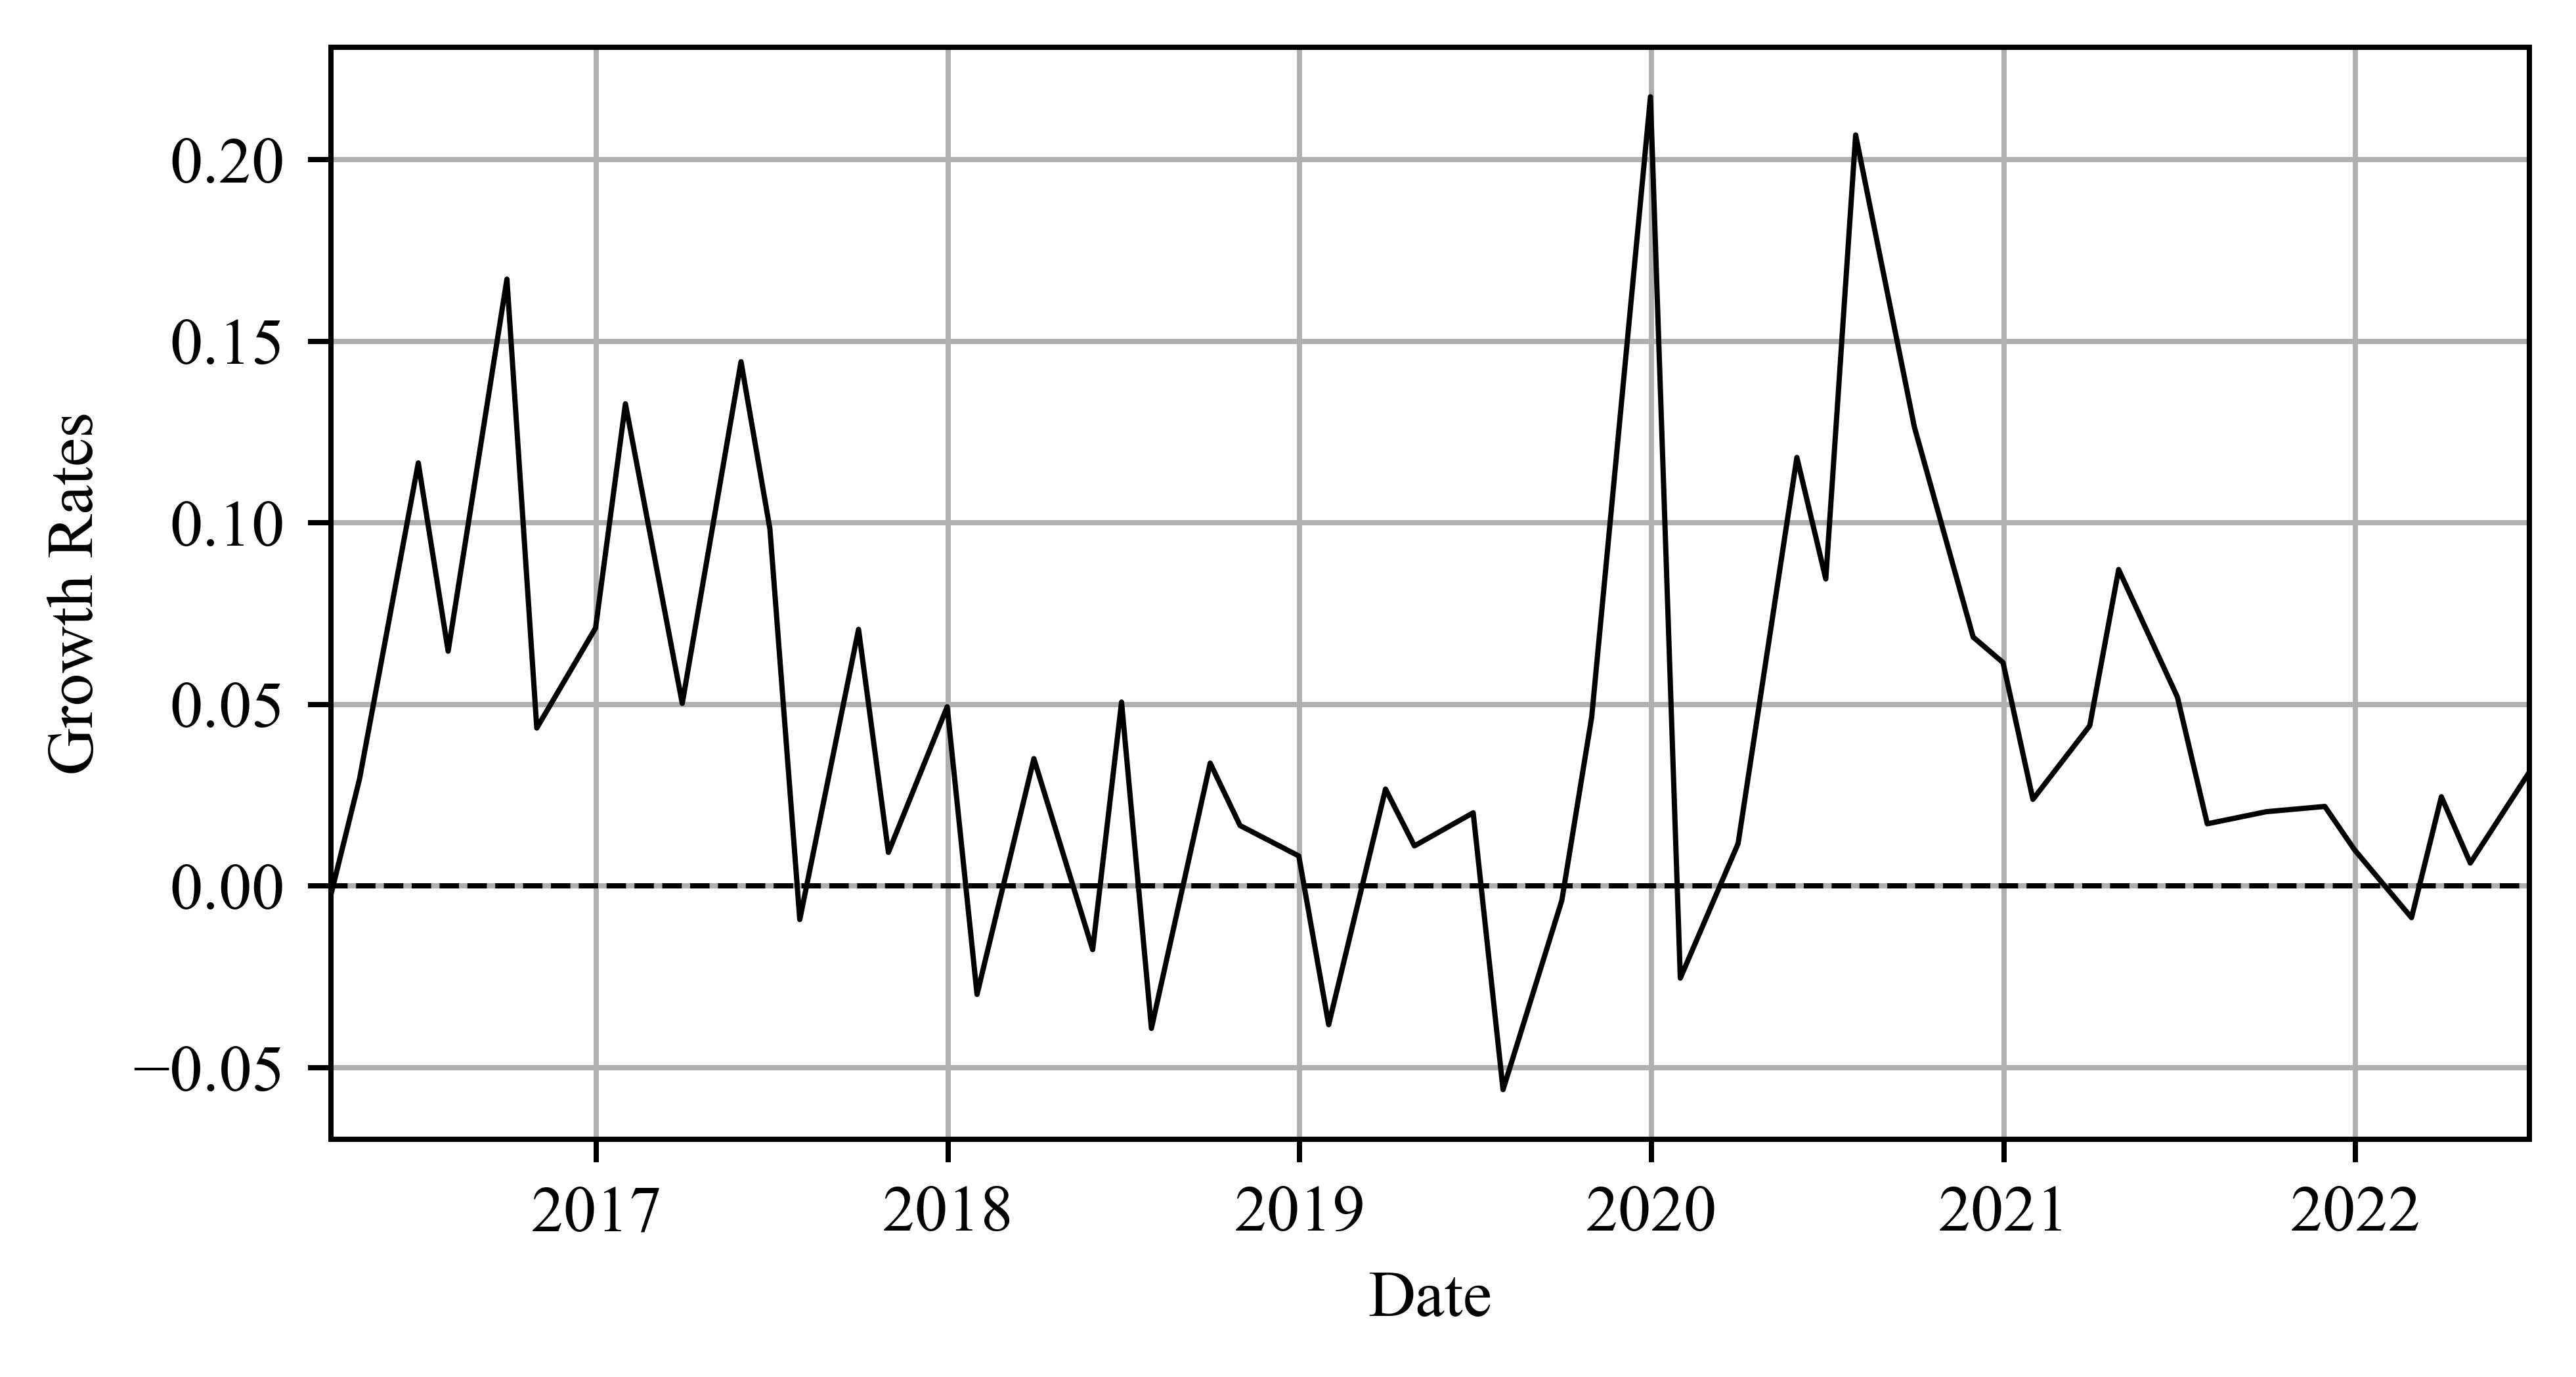

In [4]:
# verificando a taxa de crescimento das reservas para a zona do ouro no agregado

a = pd.DataFrame(df.loc['2016':'2022-06-30','Euro Area'])

a['growth'] = a['Euro Area'].pct_change()

a.loc['2016':'2020','growth'].mean()

fig, ax = plt.subplots(figsize = (6,3), dpi = 720)

ax.plot(a.index, a['growth'], linewidth = 0.8, color = 'black')

ax.plot(a.index, np.zeros(len(a.index)), linestyle = '--', linewidth = 0.8, color = 'black')

ax.set_xlim(a.index[1], a.index[-1])

ax.set(xlabel = 'Date',
       ylabel = 'Growth Rates')

ax.grid()

Pelo gráfico acima, o período após 2020 apresentou mais anos de crescimento positivo das reservas em excesso, já que a curva está em região negativa em apenas dois períodos. Entretanto, esse efeito não é visualmente aparente para os países europeus individualmente. 

In [5]:
countries = ['Germany','France','Netherlands','Spain','Italy','Luxembourg','Belgium']

df1 = df[countries]

df1 = df1.loc['2016-06-30':'2022-12-31']

df1

,Germany,France,Netherlands,Spain,Italy,Luxembourg,Belgium
DATE,,,,,,,
2016-06-30,154845.87,93330.11,132288.36,5171.82,8603.17,31460.43,9817.08
2016-07-31,164727.11,105902.16,141813.63,10222.59,9126.82,30566.20,9229.86
2016-09-30,197233.36,137133.67,148342.06,7736.52,14865.50,31462.20,8473.70
2016-10-31,210918.29,124569.81,161120.83,9701.83,12327.19,35252.30,11058.03
2016-12-31,237274.07,128920.70,157764.31,11514.46,20474.82,39003.37,12574.16
2017-01-31,268443.30,150179.26,163671.69,35680.21,28341.99,45559.16,11652.04
2017-03-31,307033.82,143378.31,172468.92,25109.01,31302.91,44762.12,12631.68
2017-05-31,339844.55,173107.56,183560.18,30769.01,53394.48,45875.22,15006.50
2017-06-30,383485.58,185930.65,186427.06,48900.38,65712.06,43790.70,16954.21


[Text(0.5, 0, 'Date'), Text(0, 0.5, '€ mi')]

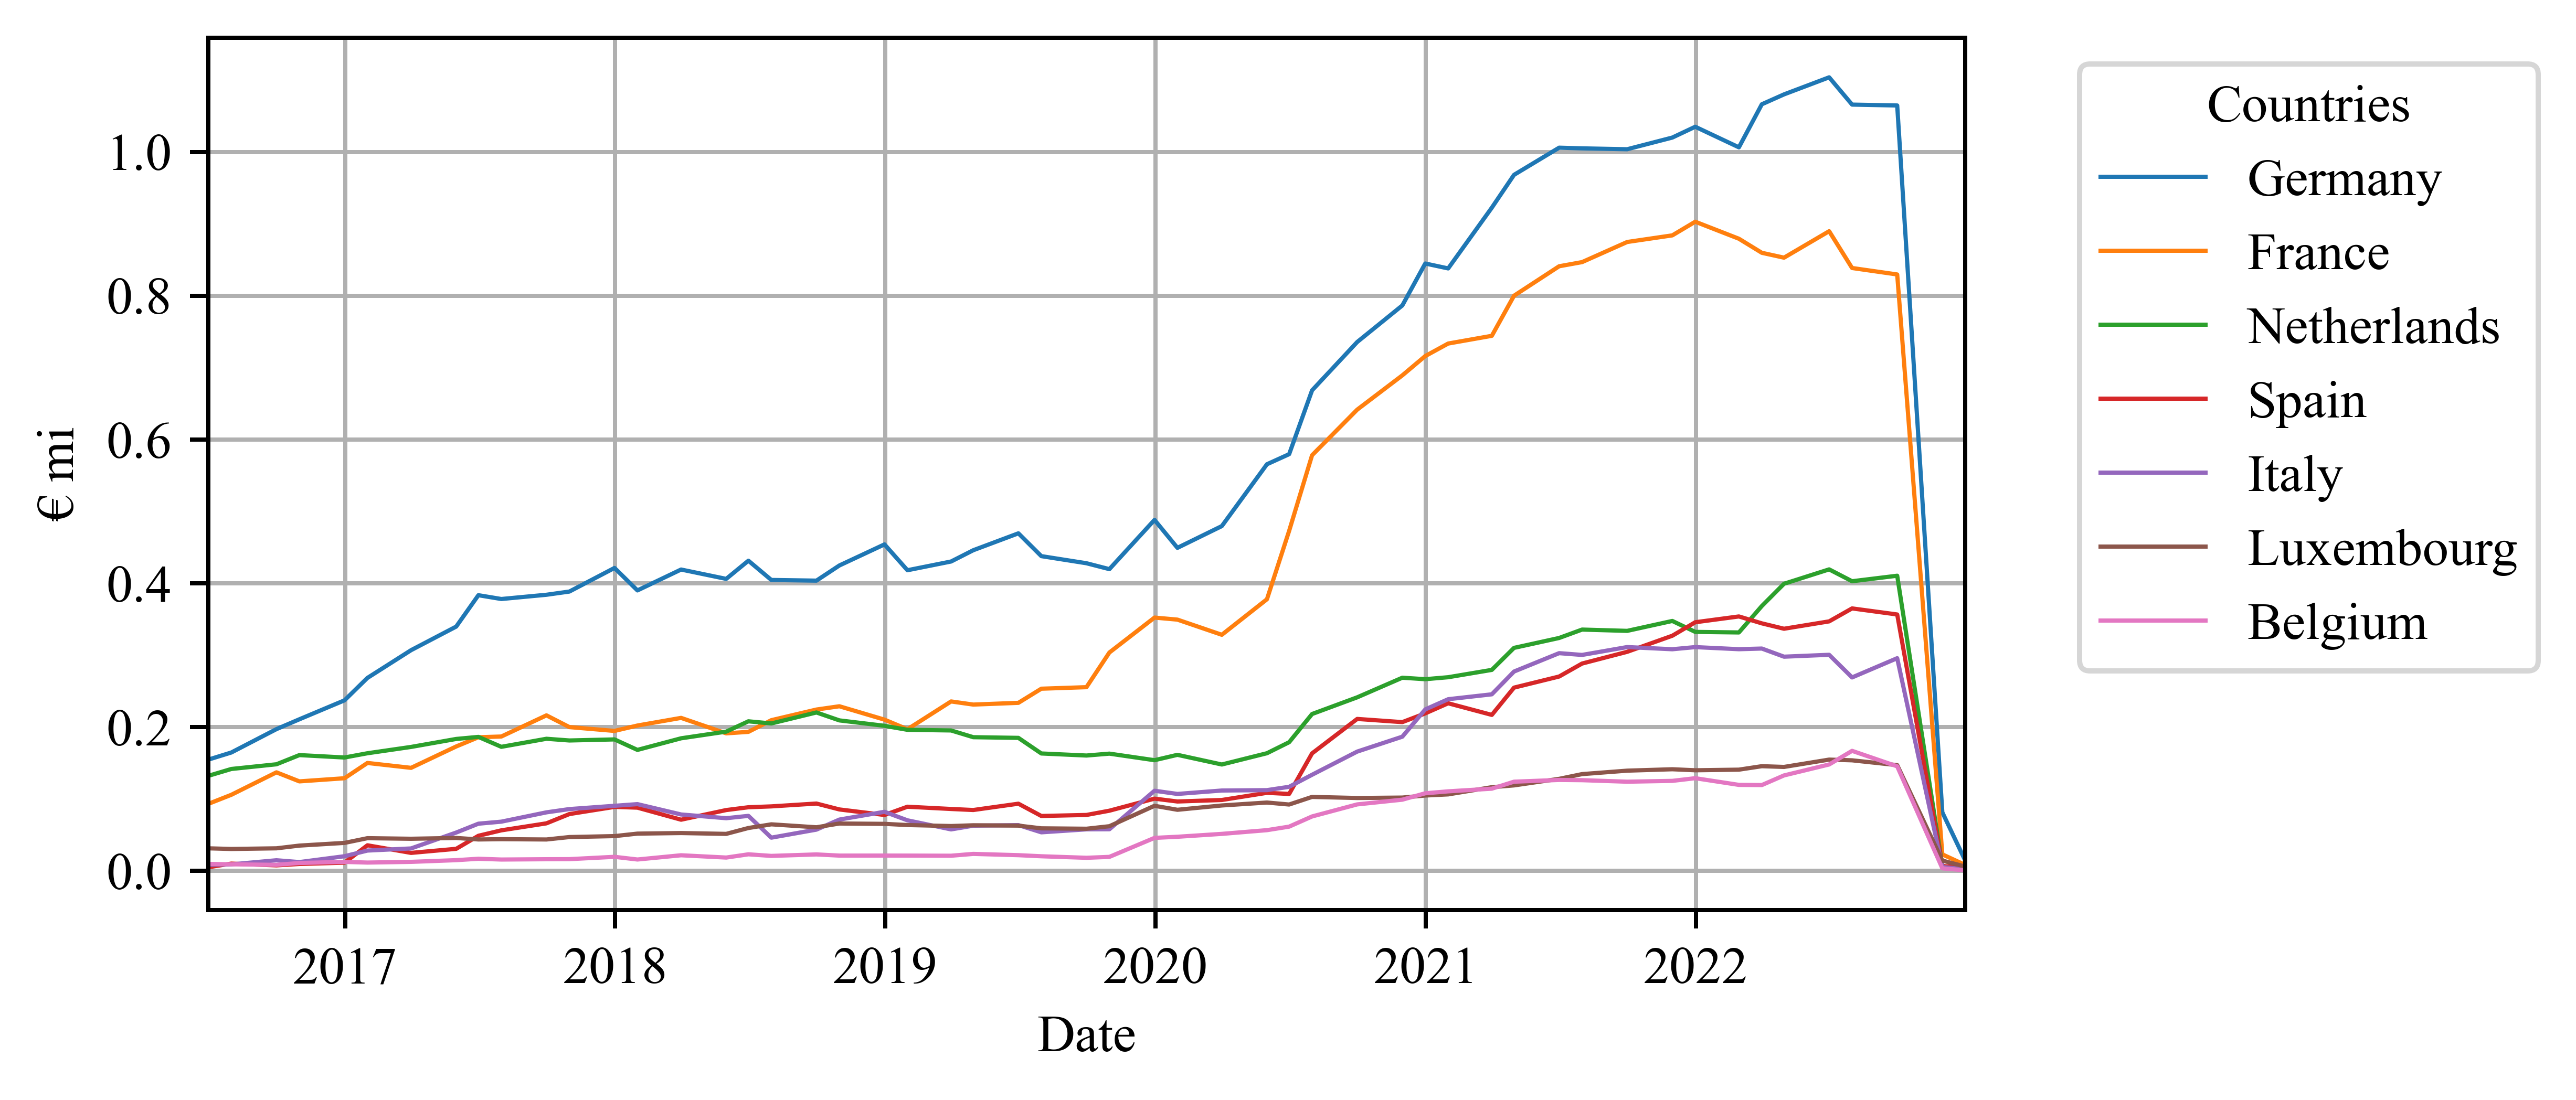

In [6]:
countries = ['Germany','France','Netherlands','Spain','Italy','Luxembourg','Belgium']

fig, ax = plt.subplots(figsize = (6,3), dpi = 720)

for i in countries: 
    
    ax.plot(df1.index, df1[i]/1000000, label = i, linewidth = 0.8)
    
ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left', title = 'Countries')

ax.set_xlim(df1.index[0], df1.index[-1])

ax.grid()

ax.set(xlabel = 'Date',
       ylabel = '€ mi')

# Chow Test

O teste de Chow serve para avaliar se os dados apresentam quebra estrutural em algum momento do tempo. Ou seja, se há mudança no tempo de parâmetro de uma regressão linear. Neste contexto, o teste de chow serve para avaliar se o parâmetro de tempo em uma regressão que use o excesso de reservas como variável endógena sofre mudança após o início da pandemia. Ou seja, se o teste for estatisticamente significativo, há evidência de que, após a pandemia, houve um aumento no acúmulo de reservas em excesso. 

In [7]:
###### Programando o teste de Chow ######

# separando a data do anúncio da OMS

date = '2020-03-31'

# selecionando o dataframe a partir de 2016 e antes do final de 2022 e criando uma variável de tempo

df1 = df.loc['2016':'2022-09-30']

df1['x'] = np.arange(len(df1))

# Separando o dataframe entre antes e depois do anúncio da OMS

df_before = df1.loc[df1.index < date]
df_after  = df1.loc[df1.index >= date]

# preparando os dados

X_before = sm.add_constant(df_before['x'])
y_before = df_before['Euro Area']

X_after = sm.add_constant(df_after['x'])
y_after = df_after['Euro Area']

# estimando os modelos

# modelos antes e depois

ols_before = sm.OLS(y_before, X_before).fit()
ols_after = sm.OLS(y_after, X_after).fit()

# modelo cheio

X_full = sm.add_constant(df1['x'])
y_full = df1['Euro Area']

ols_full = sm.OLS(y_full, X_full).fit()

# soma dos resíduos

RSS_before = np.sum(ols_before.resid**2)
RSS_after = np.sum(ols_after.resid**2)
RSS_full = np.sum(ols_full.resid**2)

# pegando os parâmetros

n_before = len(df_before)
n_after = len(df_after)
k = X_before.shape[1]

# Estatística F

F_stat = ((RSS_full - (RSS_before + RSS_after))/k)/((RSS_before + RSS_after)/(n_before + n_after - 2*k))

# p-valor

p_value = 1 - f.cdf(F_stat, k, n_before + n_after -2*k)

p_value

1.1102230246251565e-16

Como observado acima, para a União Europeia como um todo, o teste é estatisticamente significativo, já que o p-valor é em torno de $1.11x10^{-16}$. Entretanto, o mesmo teste pode não ser estatisticamente significativo para todos os países olhados individualmente. 

# Teste para vários países

Fazer o mesmo teste para múltiplos países pode não representar uma conclusão tão sólida pois uma das características da União Europeia é a mobilidade internacional de capitais e, como o sistema financeiro europeu está centralizado no banco central europeu, que fica na Alemanha, instituições de outros países podem manter reservas na Alemanha. Ou seja, o acúmulo de reservas da Alemanha pode estar sobrestimado e, o de outros países, subestimado. Portanto, o teste de Chow não tem uma interpretação causal quando vários países são levados em consideração. Podemos pegar os dados de reservas para países selecionados da zona do Euro e observar que grande parte das reservas está concentrada em um número reduzido de países. Abaixo, temos o exemplo para mês de Junho de 2022: 

In [8]:
df1 = df.loc['2016-06-30':'2022-12-31']

df1 = df1.drop('Euro Area', axis = 1)

df1 = df1.dropna(axis = 1)

valor = df.loc['2022-06-30','Euro Area']

df1 = pd.DataFrame(df1.loc['2022-06-30']).sort_values(by = '2022-06-30', ascending = False)/valor

df1['cumsum'] = df1.iloc[:,0].cumsum()

df1.columns.values[0] = 'Percentual'

df1.columns.values[1] = 'Soma Acumulada'

df1

,Percentual,Soma Acumulada
Germany,0.283853,0.283853
France,0.228812,0.512666
Netherlands,0.107859,0.620525
Spain,0.089265,0.709790
Italy,0.077309,0.787099
Luxembourg,0.039824,0.826923
Belgium,0.038082,0.865005
Austria,0.032506,0.897511
Finland,0.030331,0.927842
Ireland,0.025358,0.953200


Temos acima o percentual do excesso de reservas para os países da Zona do Euro e a soma acumulada dos percentuais para Junho de 2022. Como fica evidente, nove países concentram mais de 90% das reservas em excesso da região como um todo. Com efeito, Alemanha, França, Holanda e Espanha representam 70% do excesso de reservas. 

In [9]:
###### Ajustando os dados para o teste

# pegando os países que representam 90% do acúmulo de reservas

countries = ['Germany',
             'France',
             'Netherlands',
             'Spain','Italy',
             'Luxembourg',
             'Belgium',
             'Austria',
             'Finland']

# selecionando o período e os países do dataframe, escolhendo entre 2016 e setembro de 2022 porque é onde 
# há o início do acúmulo excessivo de reservas, a partir de 2016 e depois de setembro de 2022 a quantidade de reservas 
# acumuladas cai drasticamente devido à troca de ativos

df1 = df.loc['2016-06-30':'2022-09-30']

df1 = df1[countries]

# dropando colunas com na

# df1 = df1.dropna(axis = 1)

df1['t'] = np.arange(len(df1))

df1

,Germany,France,Netherlands,Spain,Italy,Luxembourg,Belgium,Austria,Finland,t
DATE,,,,,,,,,,
2016-06-30,154845.87,93330.11,132288.36,5171.82,8603.17,31460.43,9817.08,15164.00,36948.64,0
2016-07-31,164727.11,105902.16,141813.63,10222.59,9126.82,30566.20,9229.86,12891.00,33599.12,1
2016-09-30,197233.36,137133.67,148342.06,7736.52,14865.50,31462.20,8473.70,15396.00,46308.29,2
2016-10-31,210918.29,124569.81,161120.83,9701.83,12327.19,35252.30,11058.03,21328.00,45738.46,3
2016-12-31,237274.07,128920.70,157764.31,11514.46,20474.82,39003.37,12574.16,20468.00,50707.48,4
2017-01-31,268443.30,150179.26,163671.69,35680.21,28341.99,45559.16,11652.04,23206.00,41675.22,5
2017-03-31,307033.82,143378.31,172468.92,25109.01,31302.91,44762.12,12631.68,21828.00,54236.63,6
2017-05-31,339844.55,173107.56,183560.18,30769.01,53394.48,45875.22,15006.50,31699.00,55661.84,7
2017-06-30,383485.58,185930.65,186427.06,48900.38,65712.06,43790.70,16954.21,34342.00,57359.98,8


In [10]:
# criando um dataframe para guardar os p_valores

coefs = pd.DataFrame({'paises':countries,
                      'coeficientes antes':np.zeros(len(countries)),
                      'p-valor antes':np.zeros(len(countries)),
                      'coeficientes depois':np.zeros(len(countries)),
                      'p-valor depois':np.zeros(len(countries)),
                      'p-valores teste Chow':np.zeros(len(countries))})

coefs

,paises,coeficientes antes,p-valor antes,coeficientes depois,p-valor depois,p-valores teste Chow
0,Germany,0.0,0.0,0.0,0.0,0.0
1,France,0.0,0.0,0.0,0.0,0.0
2,Netherlands,0.0,0.0,0.0,0.0,0.0
3,Spain,0.0,0.0,0.0,0.0,0.0
4,Italy,0.0,0.0,0.0,0.0,0.0
5,Luxembourg,0.0,0.0,0.0,0.0,0.0
6,Belgium,0.0,0.0,0.0,0.0,0.0
7,Austria,0.0,0.0,0.0,0.0,0.0
8,Finland,0.0,0.0,0.0,0.0,0.0


In [11]:
###### realizando os testes

# definindo a data que separa as coisas 

date = '2020-03-31'

# fazendo os teste para todos os países

for i in countries:

    # spliting the dataframe

    df_before = df1.loc[df1.index < date]
    df_after  = df1.loc[df1.index >= date]

    # preparing the data 

    X_before = sm.add_constant(df_before['t'])
    y_before = df_before[i]

    X_after = sm.add_constant(df_after['t'])
    y_after = df_after[i]

    # models fiting

    # model before

    ols_before = sm.OLS(y_before, X_before).fit()
    ols_after = sm.OLS(y_after, X_after).fit()

    # full model 

    X_full = sm.add_constant(df1['t'])
    y_full = df1[i]

    ols_full = sm.OLS(y_full, X_full).fit()

    # residual sums 

    RSS_before = np.sum(ols_before.resid**2)
    RSS_after = np.sum(ols_after.resid**2)
    RSS_full = np.sum(ols_full.resid**2)

    # getting the parameter numbers 

    n_before = len(df_before)
    n_after = len(df_after)
    k = X_before.shape[1]

    # F stat

    F_stat = ((RSS_full - (RSS_before + RSS_after))/k)/((RSS_before + RSS_after)/(n_before + n_after - 2*k))

    # p_value

    p_value = 1 - f.cdf(F_stat, k, n_before + n_after -2*k)
    
    coefs.loc[coefs['paises'] == i, 'p-valores teste Chow'] = p_value
    
    coefs.loc[coefs['paises'] == i, 'coeficientes antes']  = ols_before.params.iloc[1]
    
    coefs.loc[coefs['paises'] == i, 'p-valor antes'] = ols_before.pvalues.iloc[1]
    
    coefs.loc[coefs['paises'] == i, 'coeficientes depois'] = ols_after.params.iloc[1]
    
    coefs.loc[coefs['paises'] == i, 'p-valor depois'] = ols_after.pvalues.iloc[1]
        



In [12]:
coefs['diferença entre os coeficientes'] = coefs['coeficientes depois'] - coefs['coeficientes antes']

coefs

,paises,coeficientes antes,p-valor antes,coeficientes depois,p-valor depois,p-valores teste Chow,diferença entre os coeficientes
0,Germany,9203.301206,5.007427e-10,28590.484247,1.246156e-09,1.456701e-11,19387.183041
1,France,6366.195212,1.809692e-12,23609.565649,8.260701e-07,7.229772e-13,17243.370437
2,Netherlands,813.378004,6.885623e-02,12568.274766,2.219749e-13,1.110223e-16,11754.896762
3,Spain,3097.207860,1.221133e-09,13703.120026,2.347602e-12,1.110223e-16,10605.912166
4,Italy,2083.660109,9.277061e-05,10450.674688,3.456926e-07,5.532880e-10,8367.014579
5,Luxembourg,1490.973562,1.943772e-12,3438.286532,1.026739e-13,5.443423e-13,1947.312971
6,Belgium,757.162859,6.951404e-07,4462.893039,5.973495e-09,1.110223e-16,3705.730180
7,Austria,756.708790,1.387245e-07,4058.126623,6.086090e-06,1.486768e-09,3301.417834
8,Finland,546.606874,5.131094e-04,3156.013532,1.044851e-11,3.612666e-13,2609.406658


Como fica aparente pela tabela acima, em todos os casos os p-valores dos coeficientes de tempo foram estatisticamente significativos ao nível de confiança de 10% para antes e depois do início da pandemia. Ao nível de confiança de 5% apenas a Holanda não tem um coeficiente estatisticamente significativo para antes da pandemia. Todos os testes de Chow para os países foram estatisticamente significativos a qualquer nível de confiança usual. 

In [13]:
# média da diferença dos coeficientes após o início da pandemia

coefs['diferença entre os coeficientes'].mean()

8769.138291979069

# Interrupted Time Series

Agora usamos a abordagem de Interrupted Time Series para verificar se a diferença entre os coeficientes antes e depois da intervenção é estatisticamente significativa. Neste caso, estimamos o seguinte modelo: 

$$Y_t = \beta_0 + \beta_1 \cdot \text{T} + \beta_2 \cdot \text{pandemia}_t + \beta_3 \cdot \text{Pandemia * T} + \varepsilon_t$$



In [14]:
# ajustando os dados para os modelos 

date = '2020-03-31'

countries = ['Germany',
             'France',
             'Netherlands',
             'Spain','Italy',
             'Luxembourg',
             'Belgium',
             'Austria',
             'Finland',
             'Euro Area']

# selecionando o período e os países do dataframe, escolhendo entre 2016 e setembro de 2022 porque é onde 
# há o início do acúmulo excessivo de reservas, a partir de 2016 e depois de setembro de 2022 a quantidade de reservas 
# acumuladas cai drasticamente devido à troca de ativos

df1 = df.loc['2016-06-30':'2022-09-30']

df1 = df1[countries]

# criando variável de tempo

df1['t'] = np.arange(len(df1))

# criando dummy para antes e depois da intervenção

df1['pandemia'] = 0

df1.loc[df1.index > date, 'pandemia'] = 1

# criando variável de tempo após a intervenção

df1['t_after'] = df1['t']

df1.loc[df1.index <= date,'t_after'] = 0

df1.loc[df1.index >  date,'t_after'] = df1.loc[df1.index >  date,'t_after'] - df1.loc[df1.index == df1.index[df1.index > date].min(),'t_after'].values[0] + 1

df1

,Germany,France,Netherlands,Spain,Italy,Luxembourg,Belgium,Austria,Finland,Euro Area,t,pandemia,t_after
DATE,,,,,,,,,,,,,
2016-06-30,154845.87,93330.11,132288.36,5171.82,8603.17,31460.43,9817.08,15164.00,36948.64,508730.59,0,0,0
2016-07-31,164727.11,105902.16,141813.63,10222.59,9126.82,30566.20,9229.86,12891.00,33599.12,541621.69,1,0,0
2016-09-30,197233.36,137133.67,148342.06,7736.52,14865.50,31462.20,8473.70,15396.00,46308.29,632130.24,2,0,0
2016-10-31,210918.29,124569.81,161120.83,9701.83,12327.19,35252.30,11058.03,21328.00,45738.46,659630.38,3,0,0
2016-12-31,237274.07,128920.70,157764.31,11514.46,20474.82,39003.37,12574.16,20468.00,50707.48,706484.40,4,0,0
2017-01-31,268443.30,150179.26,163671.69,35680.21,28341.99,45559.16,11652.04,23206.00,41675.22,800290.98,5,0,0
2017-03-31,307033.82,143378.31,172468.92,25109.01,31302.91,44762.12,12631.68,21828.00,54236.63,840524.85,6,0,0
2017-05-31,339844.55,173107.56,183560.18,30769.01,53394.48,45875.22,15006.50,31699.00,55661.84,961866.98,7,0,0
2017-06-30,383485.58,185930.65,186427.06,48900.38,65712.06,43790.70,16954.21,34342.00,57359.98,1056429.71,8,0,0


In [15]:
# rodando o modelo para a Zona do Euro como um todo

X = df1[['t','pandemia','t_after']]

X = sm.add_constant(X)

Y = df1['Euro Area']

model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Euro Area   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     641.8
Date:                Thu, 08 May 2025   Prob (F-statistic):           3.99e-38
Time:                        17:25:02   Log-Likelihood:                -687.13
No. Observations:                  51   AIC:                             1382.
Df Residuals:                      47   BIC:                             1390.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.957e+05   6.28e+04     11.084      0.000    5.69e+05    8.22e+05
t           2.671e+04   3593.921      7.432      0.000    1.95e+04    3.39e+04
pandemia    5.295e+05   1.04e+05      5.083      0.000     3.2e+05    7.39e+05
t_after     8.182e+04   7815.704     10.468      0.000    6.61e+04    9.75e+04
==============================================================================
Omnibus:                        5.073   Durbin-Watson:                   0.379
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.061
Skew:                          -0.659   Prob(JB):                        0.131
Kurtosis:                       3.419   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# ITS para vários países

Como fica visível, todos os parâmetros estimados são estatisticamente significativos aos níveis de confiança usuais. Abaixo reproduzimos o mesmo exercício para os países representativos. 

In [16]:
#criando o dataframe vazio para receber os valores

coefs = pd.DataFrame({'paises':countries[:-1],
                      'intrcp antes':np.zeros(len(countries[:-1])),
                      'pv intrcp antes':np.zeros(len(countries[:-1])),
                      'intrcp depois':np.zeros(len(countries[:-1])),
                      'pv intrcp depois':np.zeros(len(countries[:-1])),
                      'coef t antes':np.zeros(len(countries[:-1])),
                      'pv t antes':np.zeros(len(countries[:-1])),
                      'coef t depois':np.zeros(len(countries[:-1])),
                      'pv t depois':np.zeros(len(countries[:-1]))})

coefs

,paises,intrcp antes,pv intrcp antes,intrcp depois,pv intrcp depois,coef t antes,pv t antes,coef t depois,pv t depois
0,Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,France,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Netherlands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Luxembourg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X = df1[['t','pandemia','t_after']]

X = sm.add_constant(X)

for i in countries[:-1]: 
        
    Y = df1[i] 
    
    model = sm.OLS(Y,X).fit()
    
    coefs.loc[coefs['paises'] == i,'intrcp antes']  = model.params.iloc[0]

    coefs.loc[coefs['paises'] == i,'pv intrcp antes'] = model.pvalues.iloc[0]

    coefs.loc[coefs['paises'] == i,'intrcp depois'] = model.params.iloc[2]

    coefs.loc[coefs['paises'] == i,'pv intrcp depois'] = model.pvalues.iloc[2]

    coefs.loc[coefs['paises'] == i,'coef t antes'] = model.params.iloc[1]

    coefs.loc[coefs['paises'] == i,'pv t antes'] = model.pvalues.iloc[1]

    coefs.loc[coefs['paises'] == i,'coef t depois'] = model.params.iloc[3]

    coefs.loc[coefs['paises'] == i,'pv t depois'] = model.pvalues.iloc[3]


In [18]:
coefs

,paises,intrcp antes,pv intrcp antes,intrcp depois,pv intrcp depois,coef t antes,pv t antes,coef t depois,pv t depois
0,Germany,240518.497016,1.635335e-16,129633.239974,1.908999e-04,8991.735016,1.572530e-10,17516.796796,2.949276e-09
1,France,110420.082077,5.642420e-07,238083.738983,1.344798e-09,6520.656593,3.004382e-07,14287.781279,2.567006e-07
2,Netherlands,168163.991875,9.761079e-28,-1979.106303,8.675960e-01,558.912907,1.765327e-01,11555.877018,3.111665e-17
3,Spain,20720.489476,4.265681e-03,17203.514347,1.396342e-01,3011.712573,9.302501e-10,10306.987570,6.511499e-16
4,Italy,28387.252016,7.974843e-03,51298.939522,4.107518e-03,2203.383565,4.746458e-04,7806.524390,1.770253e-07
5,Luxembourg,31310.508266,1.434183e-19,10608.505594,3.578066e-03,1576.824847,1.927752e-17,1885.356890,3.237452e-09
6,Belgium,7214.073145,2.864329e-02,37515.693048,6.304995e-09,880.722694,1.573879e-05,3327.631164,7.342104e-11
7,Austria,21293.678831,4.730402e-06,25103.140187,6.144204e-04,750.285347,2.598940e-03,2969.730375,5.589197e-07
8,Finland,47088.115524,1.622350e-25,4875.162976,1.967834e-01,566.596750,5.968358e-05,2563.746250,4.742115e-12


# Usando o modelo ARIMA para gerar um contrafactual

Por fim, usamos estimamos um modelo ARIMA (3,1,3) para simular o que seria a trajetória para a série em cada país se não tivesse ocorrido a pandemia. Assim, primeiro fazemos o teste de Dickey-Fuller aumentado para a primeira diferença para verificar a presença de estacionariedade nas séries em questão. A única série que não possui valor estatisticamente significativo para a primeira diferença é a série da Holanda e, portanto, retiramos este país da amostra e mantemos os outros para realizar o exercício de comparação

In [19]:
# ajeitando os dados

date = '2020-03-31'

countries = ['Germany',
             'France',
             'Netherlands',
             'Spain','Italy',
             'Luxembourg',
             'Belgium',
             'Austria',
             'Finland',
             'Euro Area']

# selecionando o período e os países do dataframe, escolhendo entre 2016 e setembro de 2022 porque é onde 
# há o início do acúmulo excessivo de reservas, a partir de 2016 e depois de setembro de 2022 a quantidade de reservas 
# acumuladas cai drasticamente devido à troca de ativos

df1 = df.loc['2016-12-31':'2022-09-30']

df1 = df1[countries]

df1

,Germany,France,Netherlands,Spain,Italy,Luxembourg,Belgium,Austria,Finland,Euro Area
DATE,,,,,,,,,,
2016-12-31,237274.07,128920.70,157764.31,11514.46,20474.82,39003.37,12574.16,20468.00,50707.48,706484.40
2017-01-31,268443.30,150179.26,163671.69,35680.21,28341.99,45559.16,11652.04,23206.00,41675.22,800290.98
2017-03-31,307033.82,143378.31,172468.92,25109.01,31302.91,44762.12,12631.68,21828.00,54236.63,840524.85
2017-05-31,339844.55,173107.56,183560.18,30769.01,53394.48,45875.22,15006.50,31699.00,55661.84,961866.98
2017-06-30,383485.58,185930.65,186427.06,48900.38,65712.06,43790.70,16954.21,34342.00,57359.98,1056429.71
2017-07-31,378191.75,186951.06,172619.80,56470.75,68541.14,44187.40,15877.00,30830.00,56352.85,1046670.87
2017-09-30,384097.65,216386.31,183820.05,66208.80,81493.80,43757.83,16306.77,33453.00,60796.16,1120638.89
2017-10-31,388566.83,200057.67,181449.81,79105.39,86041.99,47134.29,16416.82,35073.00,58471.05,1131016.41
2017-12-31,421387.00,194739.85,182927.34,89083.38,90599.95,48449.94,19635.85,35039.00,61664.02,1186835.99


In [20]:
# verificando estacionariedade com o teste Dickey-Fuller aumentado para a primeira diferença 
# das séries dos países

df2 = df1.loc[df1.index < date]

testes = dict(zip(df1.columns,[adfuller(df2[i].diff()[1:])[1] for i in df1.columns]))

testes

{'Germany': 0.0011778776014001978,
 'France': 5.366107009377931e-05,
 'Netherlands': 0.3330957144996342,
 'Spain': 3.187862432888701e-07,
 'Italy': 4.428856680338837e-05,
 'Luxembourg': 0.03562266446997422,
 'Belgium': 0.004547996296185442,
 'Austria': 0.03457902951207231,
 'Finland': 0.03228288667677028,
 'Euro Area': 0.028442254904408226}

Ao nível de confiança de 5%, apenas a série para a primeira diferença da Holanda não indica estacionariedade. Portanto, vamos fazer uma previsão para um contrafactual usando o modelo ARIMA para todos os outros países menos a Holanda. 

In [21]:
# pegando os países sem holanda

df2 = df1.loc[df1.index < date]

df2 = df2.drop(columns = ['Netherlands'])

# criando dataframe para as previsões

previsoes = pd.DataFrame(dict(zip(df2.columns,[np.zeros(22) for i in df2.columns])))

# estimando os ARIMAs

for i in df2.columns: 

    modelo = ARIMA(df2[i].reset_index(drop = True), order = (4,1,5))

    modelo = modelo.fit()

    previsao = modelo.forecast(steps = 22)
    
    previsoes[i] = previsao.values

Para os gráficos a seguir, a curva em azul é o que foi efetivamente observado enquanto a curva em laranja é o contrafactual estimado pelo modelo ARIMA. Primeiro é apresentado o gráfico para a zona do euro como um todo e, em seguida, os gráficos para os países selecionados

Text(0.5, 1.0, 'Euro Area')

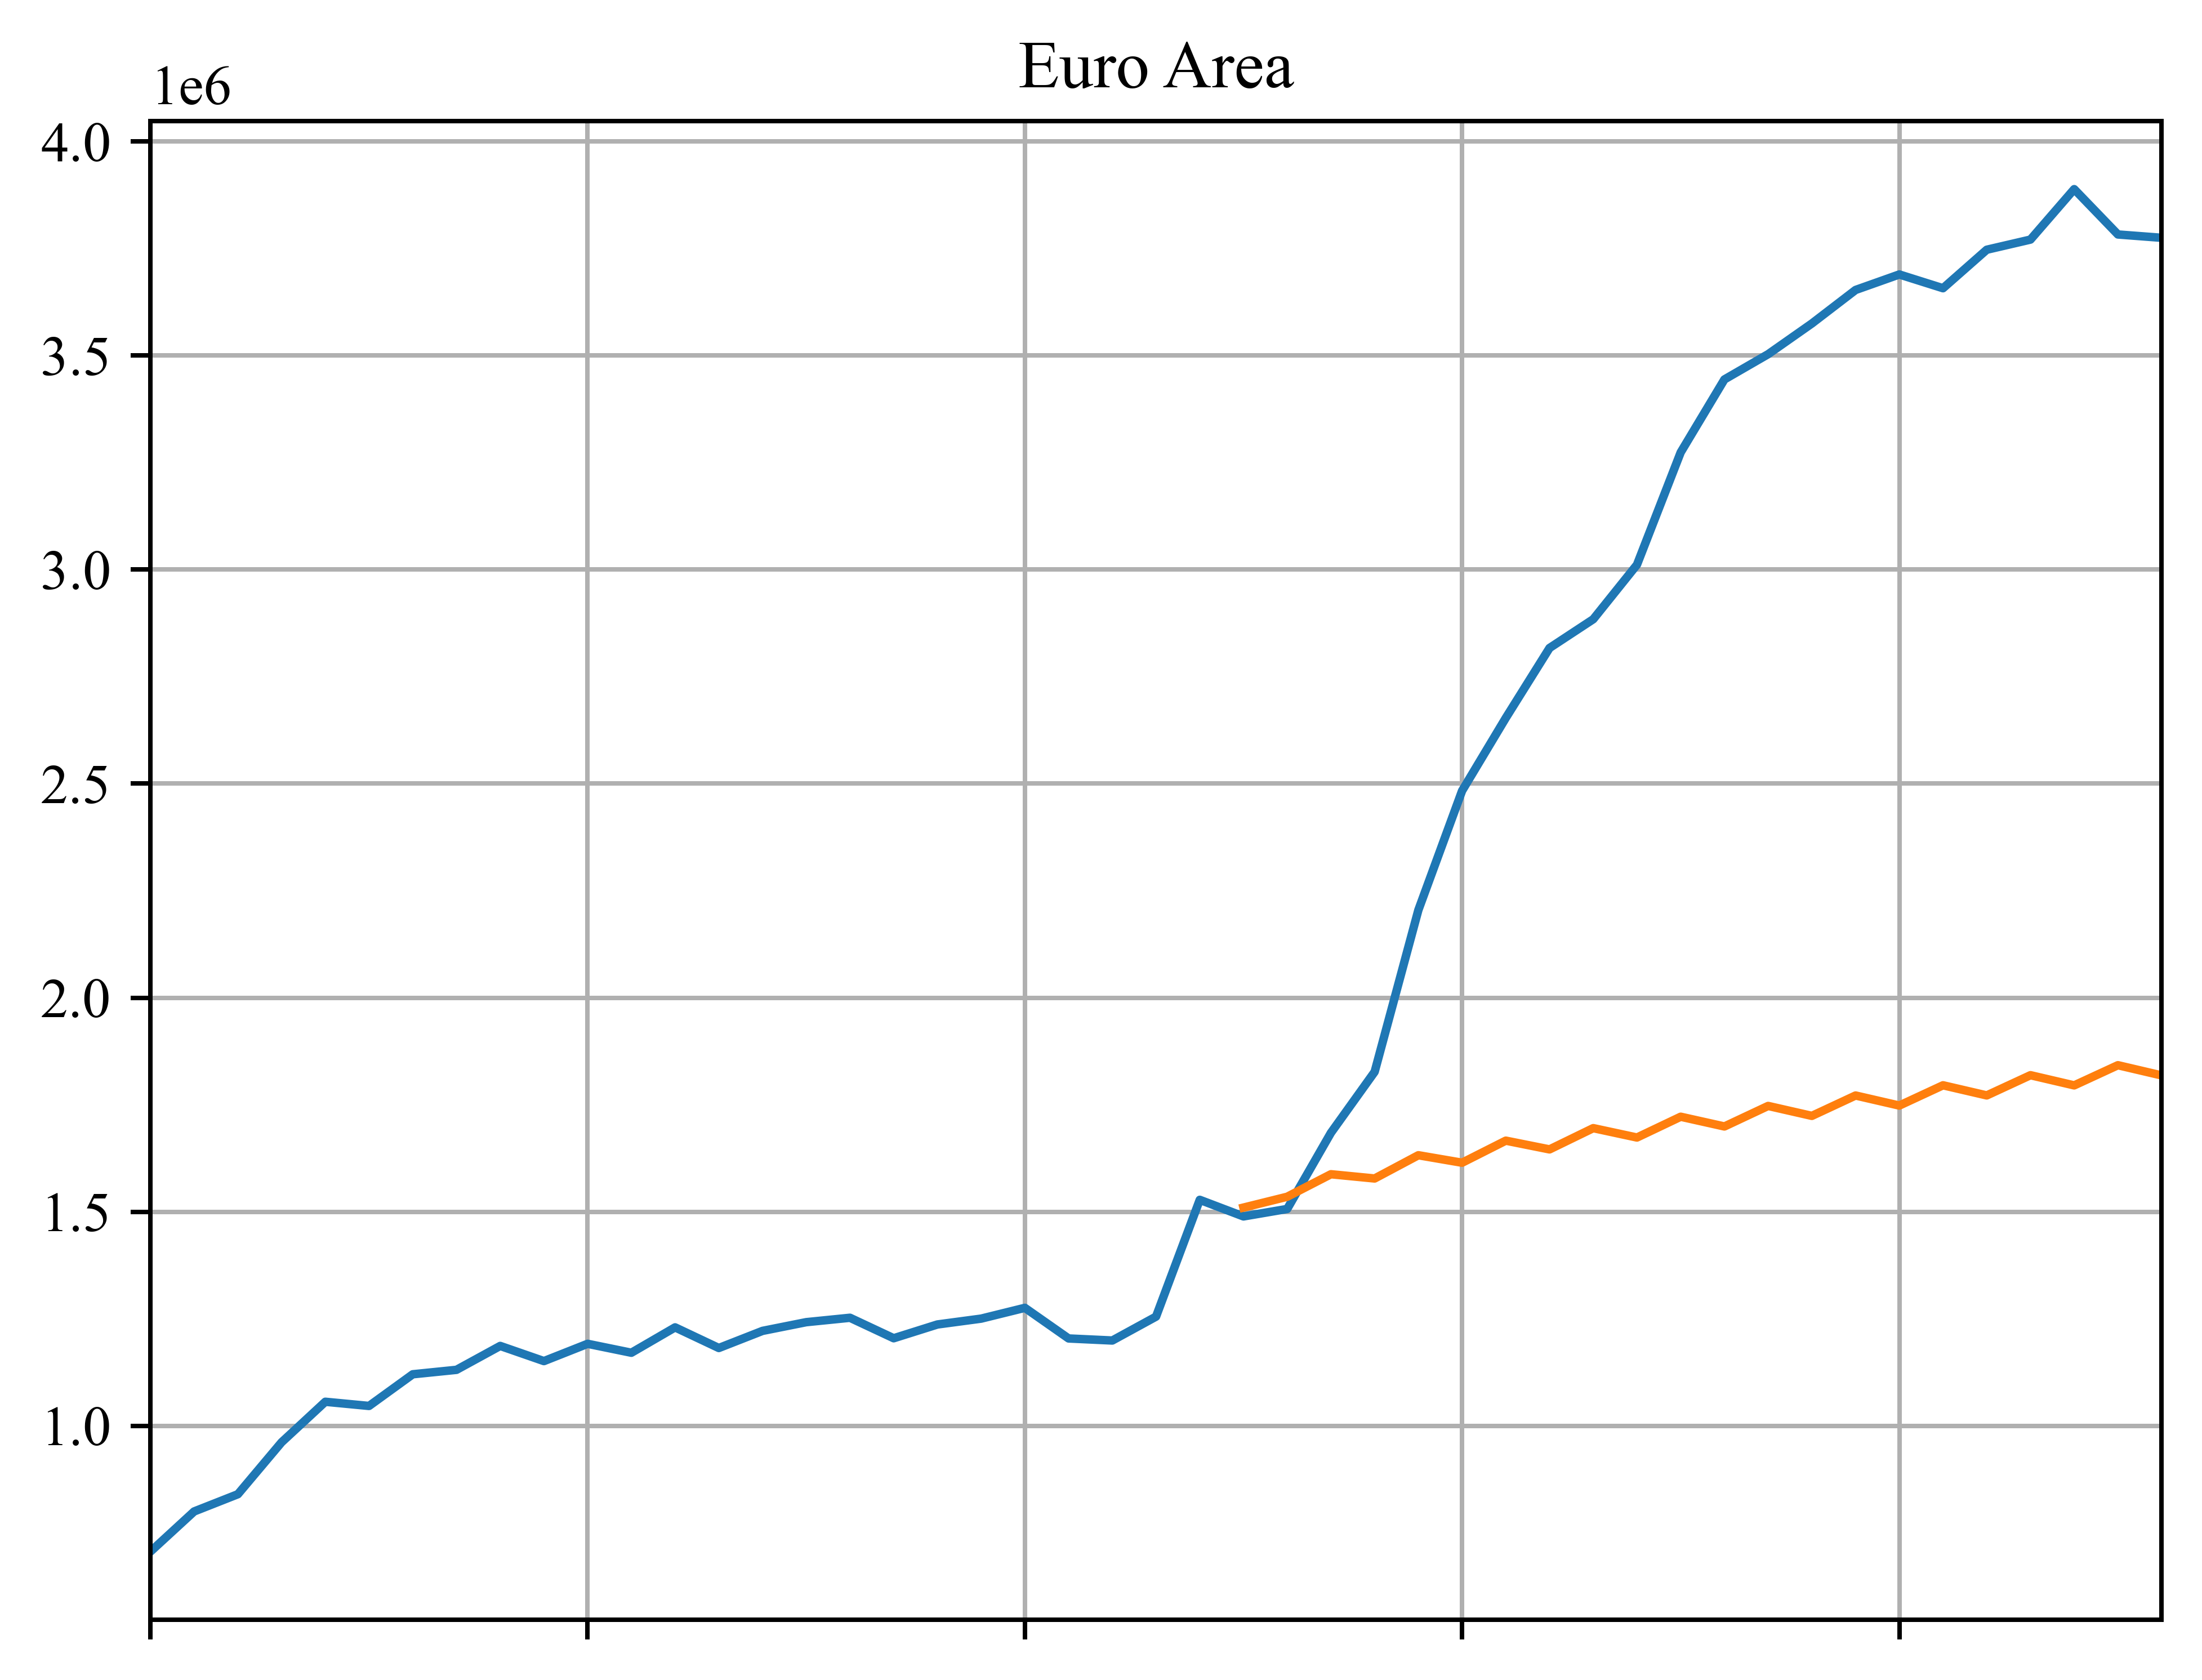

In [22]:
fig, ax = plt.subplots(dpi = 720)

ax.plot(range(47), df1['Euro Area'], label = 'observado')
ax.plot(range(25,47),previsoes['Euro Area'] , label = 'previsto')
ax.grid()
ax.set_xlim(0,46)
ax.set_xticklabels([])
ax.set_title('Euro Area')

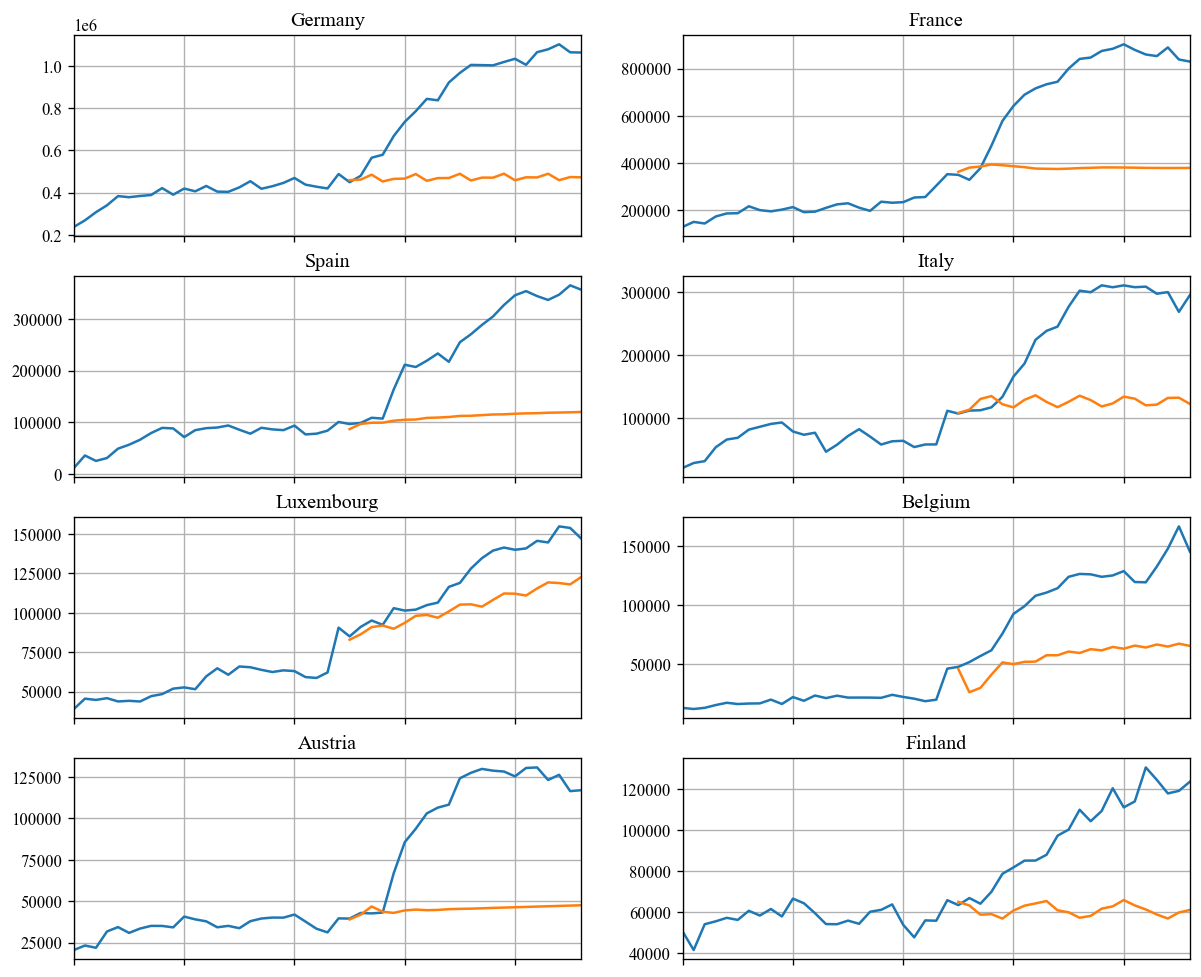

In [23]:
# Fazendo um gráfico com as previsões e as mudanças de tendência para os países

paises = ['Germany','France','Spain','Italy','Luxembourg','Belgium','Austria','Finland']

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), dpi=120)

for i, pais in enumerate(paises): 
    
    eixo = ax.flat[i]
    eixo.plot(range(47), df1[pais], label = 'observado')
    eixo.plot(range(25,47),previsoes[pais] , label = 'previsto')
    eixo.grid()
    eixo.set_xlim(0,46)
    eixo.set_xticklabels([])
    eixo.set_title(pais)